In [2]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import necessary libraries
import json
import pandas as pd

# STEP 3: Load the JSON file
json_path = "/content/drive/MyDrive/reviews.json"  # adjust if needed
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# STEP 4: Flatten the nested structure into a DataFrame
flattened_reviews = []

for paper in data['paper']:
    paper_id = paper.get('id')
    preliminary_decision = paper.get('preliminary_decision')

    for review in paper['review']:
        flattened_review = {
            'paper_id': paper_id,
            'preliminary_decision': preliminary_decision,
            'review_id': review.get('id'),
            'confidence': review.get('confidence'),
            'evaluation': review.get('evaluation'),
            'orientation': review.get('orientation'),
            'language': review.get('lan'),
            'remarks': review.get('remarks'),
            'text': review.get('text'),
            'timespan': review.get('timespan')
        }
        flattened_reviews.append(flattened_review)

# STEP 5: Create the DataFrame
df = pd.DataFrame(flattened_reviews)
print("✅ Flattened DataFrame created. Shape:", df.shape)
print(df.head(2))


Mounted at /content/drive
✅ Flattened DataFrame created. Shape: (405, 10)
   paper_id preliminary_decision  review_id confidence evaluation orientation  \
0         1               accept          1          4          1           0   
1         1               accept          2          4          1           1   

  language remarks                                               text  \
0       es          - El artículo aborda un problema contingente y...   
1       es          El artículo presenta recomendaciones prácticas...   

     timespan  
0  2010-07-05  
1  2010-07-05  


STEP 2: TEXT CLEANING & PREPROCESSING

In [3]:
# STEP 6: Install and import NLP libraries
!pip install nltk spacy
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm

import string
import re
import spacy
import nltk
from nltk.corpus import stopwords

# STEP 7: Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# STEP 8: Load language models and stopwords
nlp_es = spacy.load('es_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

spanish_stopwords = set(stopwords.words('spanish'))
english_stopwords = set(stopwords.words('english'))

# STEP 9: Clean & preprocess text
def preprocess_text(text, language='es'):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    if language == 'es':
        doc = nlp_es(text)
        stopwords_lang = spanish_stopwords
    else:
        doc = nlp_en(text)
        stopwords_lang = english_stopwords

    tokens = [token.lemma_ for token in doc if token.text not in stopwords_lang and not token.is_space]
    return ' '.join(tokens)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 101.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


APPLY CLEANING + REMOVE EMPTY REVIEWS

In [4]:
# STEP 10: Split data by language
df_spanish = df[df['language'] == 'es'].copy()
df_english = df[df['language'] == 'en'].copy()

# STEP 11: Apply preprocessing
df_spanish['cleaned_text'] = df_spanish['text'].apply(preprocess_text, language='es')
df_english['cleaned_text'] = df_english['text'].apply(preprocess_text, language='en')

# STEP 12: Combine preprocessed data
df_cleaned = pd.concat([
    df_spanish[['text', 'cleaned_text', 'language', 'confidence', 'evaluation', 'orientation']],
    df_english[['text', 'cleaned_text', 'language', 'confidence', 'evaluation', 'orientation']]
], ignore_index=True)

# STEP 13: Create empty flag and drop truly empty reviews
df_cleaned['empty_cleaned'] = df_cleaned['cleaned_text'].apply(lambda x: x.strip() == "")
df_cleaned = df_cleaned[df_cleaned['empty_cleaned'] == False].reset_index(drop=True)

print("✅ Cleaned reviews shape:", df_cleaned.shape)
print(df_cleaned[['cleaned_text', 'language', 'orientation']].head())



#Length-Based Features

# Add word count and char count
df_cleaned['word_count'] = df_cleaned['cleaned_text'].apply(lambda x: len(str(x).split()))
df_cleaned['char_count'] = df_cleaned['text'].apply(lambda x: len(str(x)))

# Preview
print(df_cleaned[['cleaned_text', 'word_count', 'char_count']].head())

✅ Cleaned reviews shape: (399, 7)
                                        cleaned_text language orientation
0  artículo abordar problema contingente relevant...       es           0
1  artículo presentar recomendación práctico desa...       es           1
2  tema interesante poder ser mucho ayuda guía in...       es           1
3  explicar forma ordenado didáctico experiencia ...       es           1
4  autor describir metodología desarrollar forma ...       es           0
                                        cleaned_text  word_count  char_count
0  artículo abordar problema contingente relevant...          45         575
1  artículo presentar recomendación práctico desa...          50         618
2  tema interesante poder ser mucho ayuda guía in...         118        1259
3  explicar forma ordenado didáctico experiencia ...         119        1350
4  autor describir metodología desarrollar forma ...         162        1938


STEP-2: EDA


I have divided it into four phases below   


 Phase 1: Class Distribution Analysis

<ipython-input-5-f77858ccc862>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='orientation', data=df_cleaned, palette='Set2')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


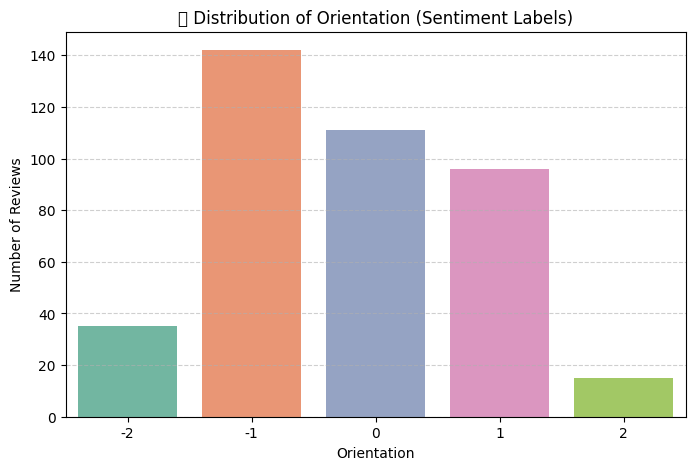

<ipython-input-5-f77858ccc862>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='evaluation', data=df_cleaned, palette='Set3')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


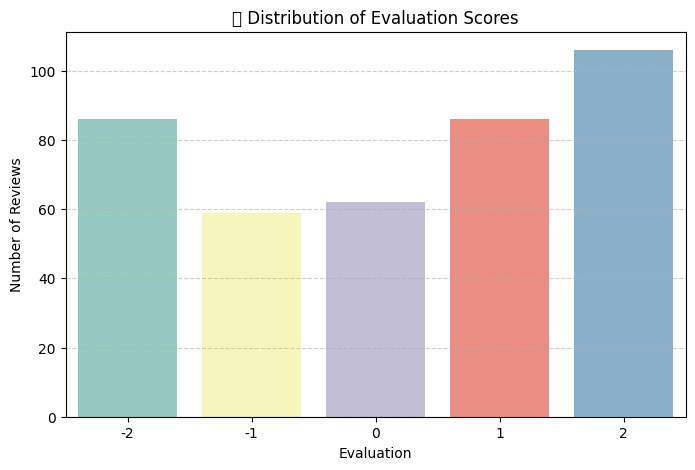

🔁 Crosstab: Orientation vs Evaluation
evaluation   -2  -1   0   1   2
orientation                    
-2           30   3   2   0   0
-1           50  45  31  11   5
 0            6  11  24  45  25
 1            0   0   5  29  62
 2            0   0   0   1  14


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


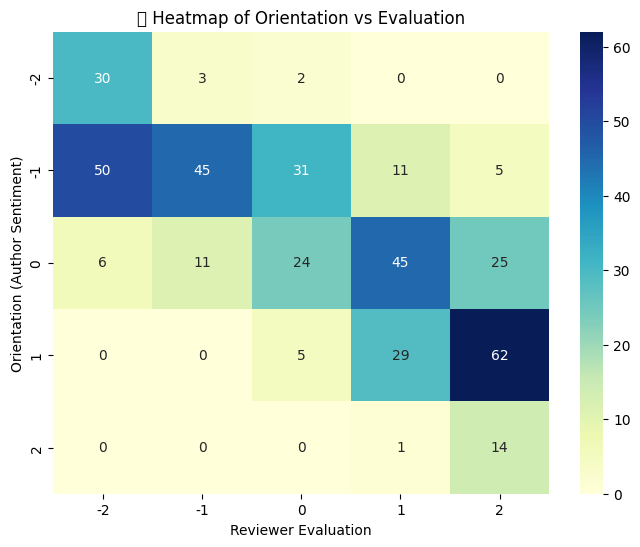

In [5]:
#Phase 1: Class Distribution Analysis
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to numeric (in case they are object type)
df_cleaned['orientation'] = pd.to_numeric(df_cleaned['orientation'], errors='coerce')
df_cleaned['evaluation'] = pd.to_numeric(df_cleaned['evaluation'], errors='coerce')

# 1. Distribution of orientation (target label)
plt.figure(figsize=(8, 5))
sns.countplot(x='orientation', data=df_cleaned, palette='Set2')
plt.title("📊 Distribution of Orientation (Sentiment Labels)")
plt.xlabel("Orientation")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 2. Distribution of evaluation scores
plt.figure(figsize=(8, 5))
sns.countplot(x='evaluation', data=df_cleaned, palette='Set3')
plt.title("📊 Distribution of Evaluation Scores")
plt.xlabel("Evaluation")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 3. Heatmap: Crosstab between orientation and evaluation
comparison_ct = pd.crosstab(df_cleaned['orientation'], df_cleaned['evaluation'])
print("🔁 Crosstab: Orientation vs Evaluation")
print(comparison_ct)

plt.figure(figsize=(8, 6))
sns.heatmap(comparison_ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title("🧠 Heatmap of Orientation vs Evaluation")
plt.xlabel("Reviewer Evaluation")
plt.ylabel("Orientation (Author Sentiment)")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


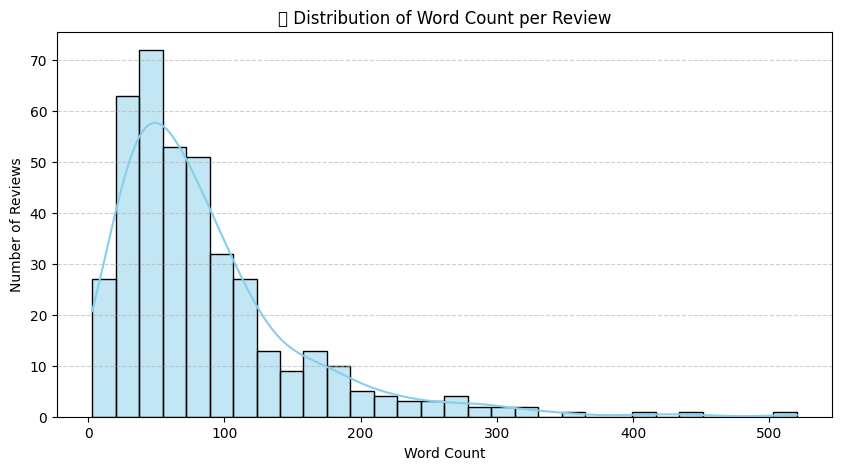

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


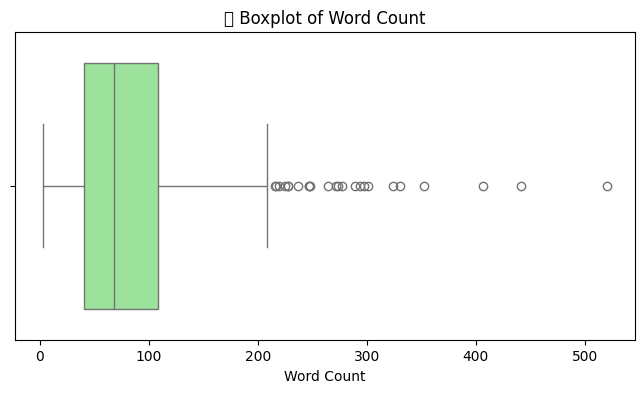

<ipython-input-6-09bf0a82718f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='orientation', y='word_count', data=df_cleaned, palette='Set2')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


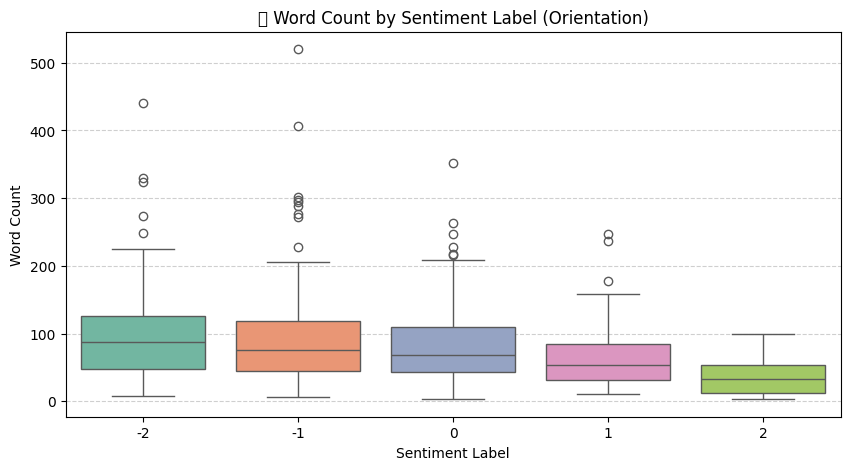

In [6]:
# Review Length Analysis
# 1. Histogram of word counts
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned['word_count'], bins=30, kde=True, color='skyblue')
plt.title("📝 Distribution of Word Count per Review")
plt.xlabel("Word Count")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 2. Boxplot of word count
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_cleaned['word_count'], color='lightgreen')
plt.title("📦 Boxplot of Word Count")
plt.xlabel("Word Count")
plt.show()

# 3. Word Count by Sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x='orientation', y='word_count', data=df_cleaned, palette='Set2')
plt.title("🧠 Word Count by Sentiment Label (Orientation)")
plt.xlabel("Sentiment Label")
plt.ylabel("Word Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


Phase 3: Most Frequent Words (Unigrams) + WordClouds

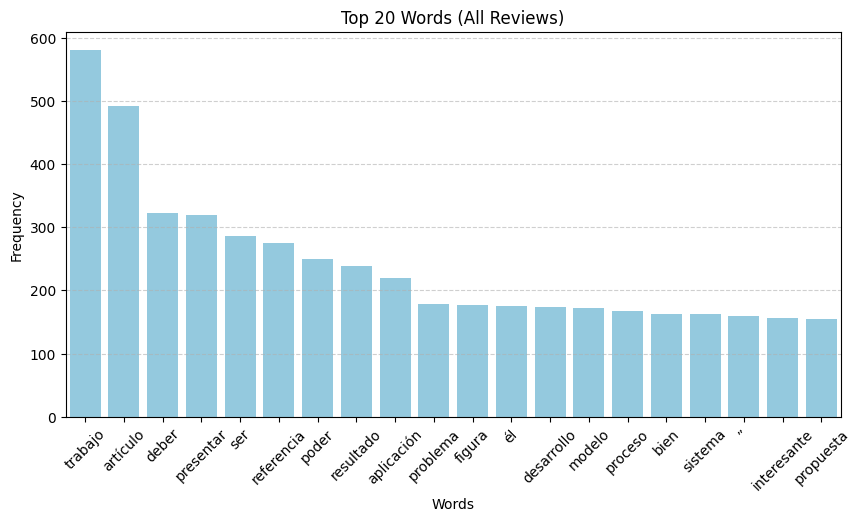

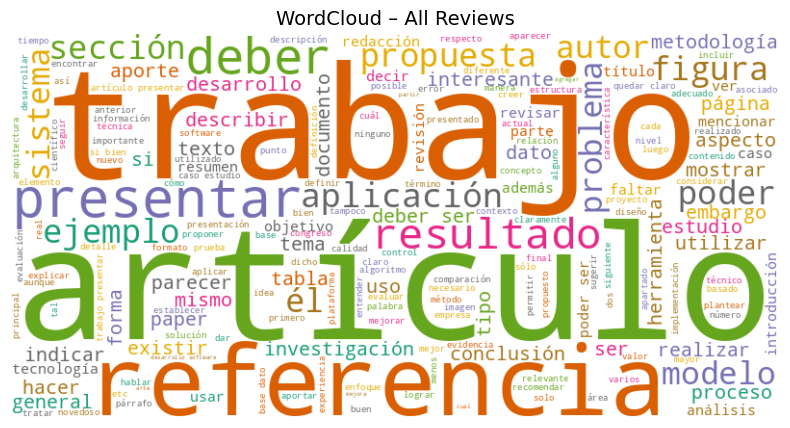

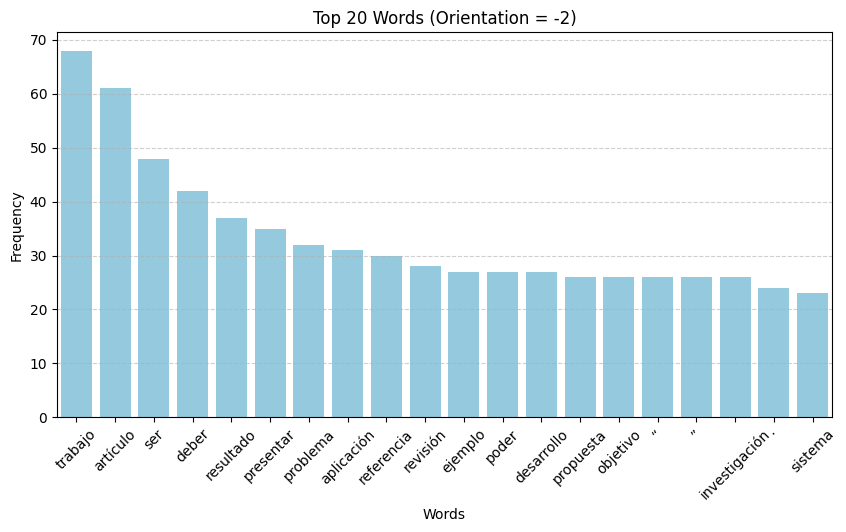

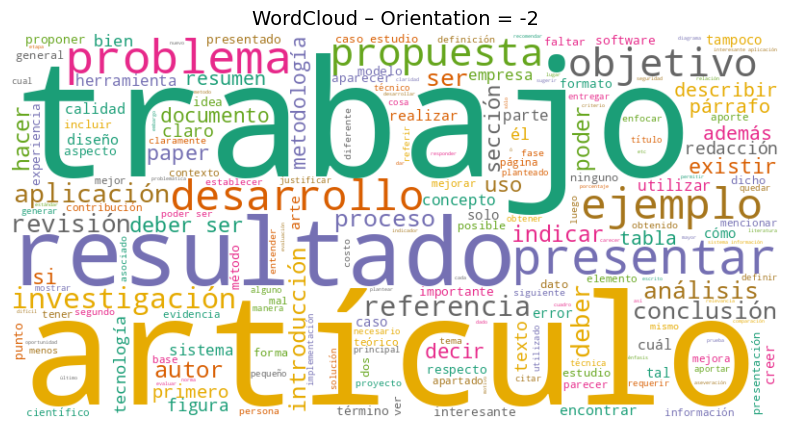

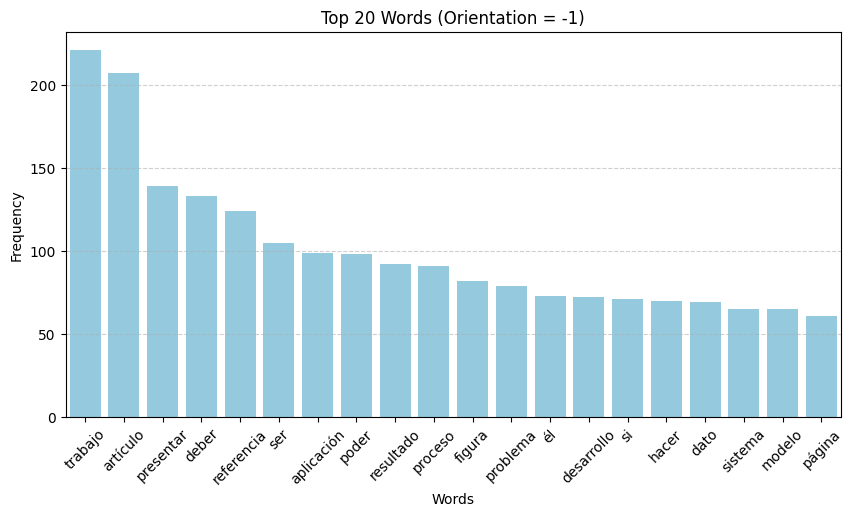

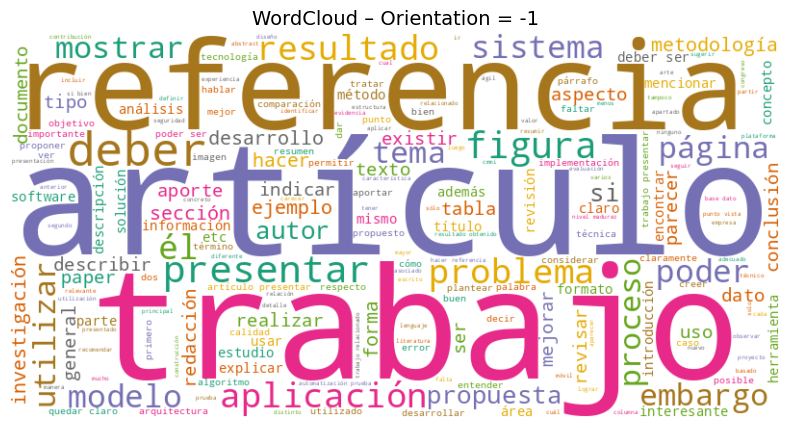

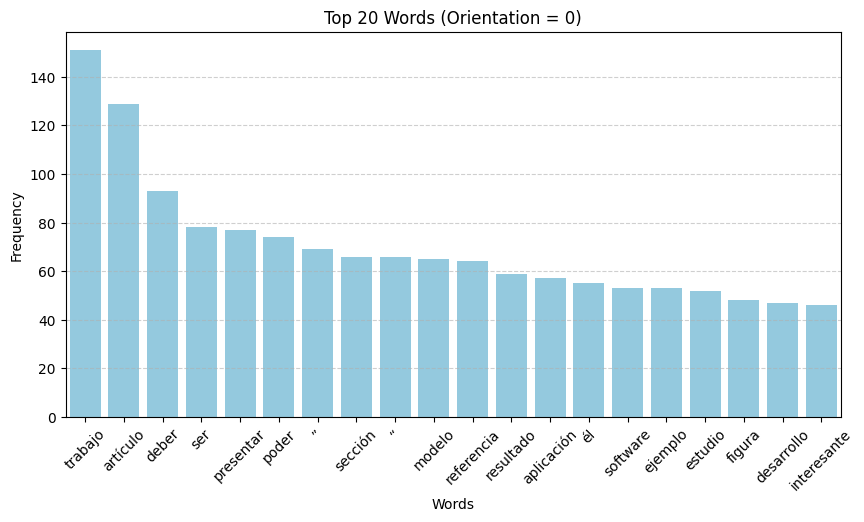

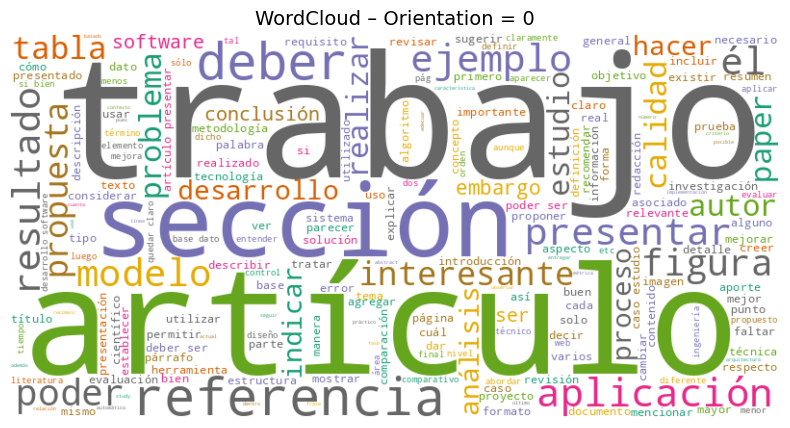

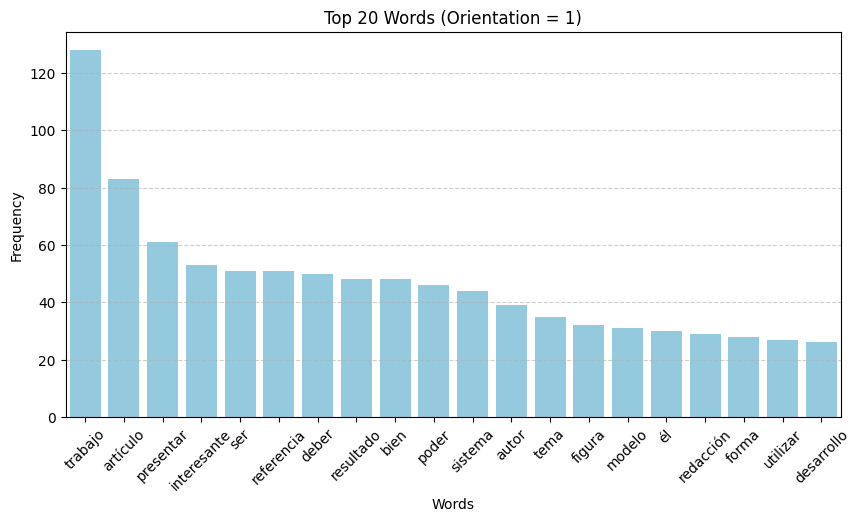

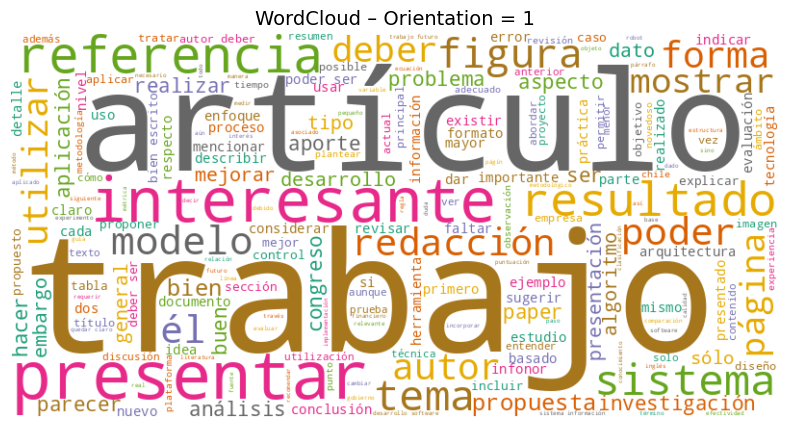

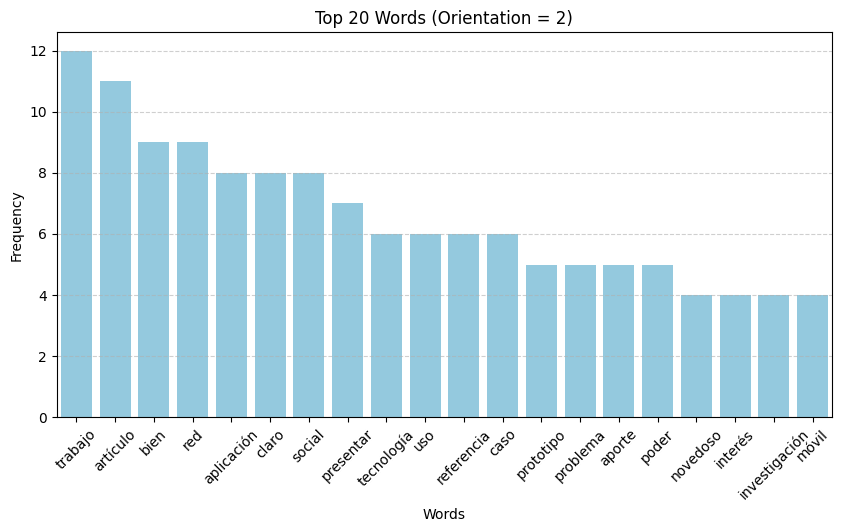

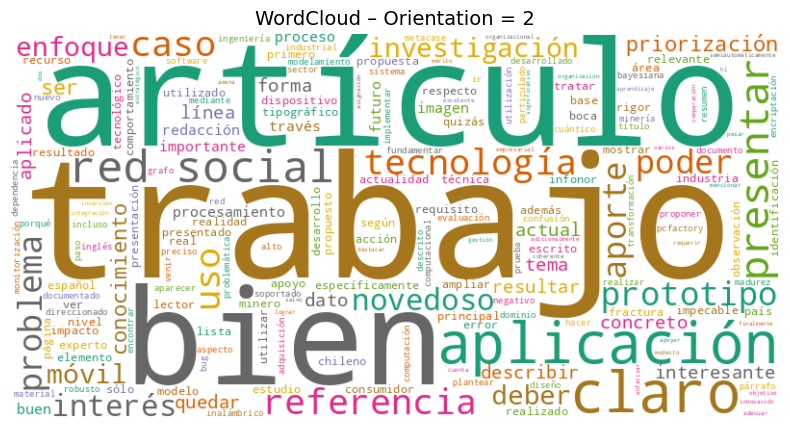

In [7]:
#Phase 3: Most Frequent Words (Unigrams) + WordClouds
from collections import Counter
from wordcloud import WordCloud

# Helper function
def get_top_n_words(corpus, n=20):
    words = " ".join(corpus).split()
    counter = Counter(words)
    return counter.most_common(n)

def plot_top_words(counter, title, color='skyblue'):
    words, counts = zip(*counter)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(words), y=list(counts), color=color)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

def plot_wordcloud(corpus, title):
    text = " ".join(corpus)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

# All reviews
overall_top_words = get_top_n_words(df_cleaned['cleaned_text'], n=20)
plot_top_words(overall_top_words, "Top 20 Words (All Reviews)")
plot_wordcloud(df_cleaned['cleaned_text'], "WordCloud – All Reviews")

# Top words by sentiment
for sentiment in sorted(df_cleaned['orientation'].unique()):
    subset = df_cleaned[df_cleaned['orientation'] == sentiment]
    title = f"Orientation = {sentiment}"
    top_words = get_top_n_words(subset['cleaned_text'], n=20)
    plot_top_words(top_words, f"Top 20 Words ({title})")
    plot_wordcloud(subset['cleaned_text'], f"WordCloud – {title}")


Phase 4: N-gram Analysis (Bigrams & Trigrams)

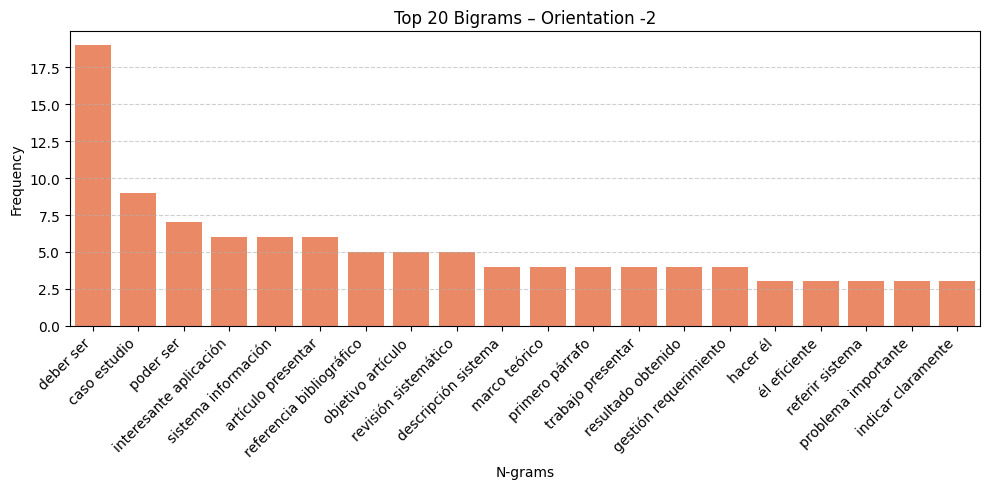

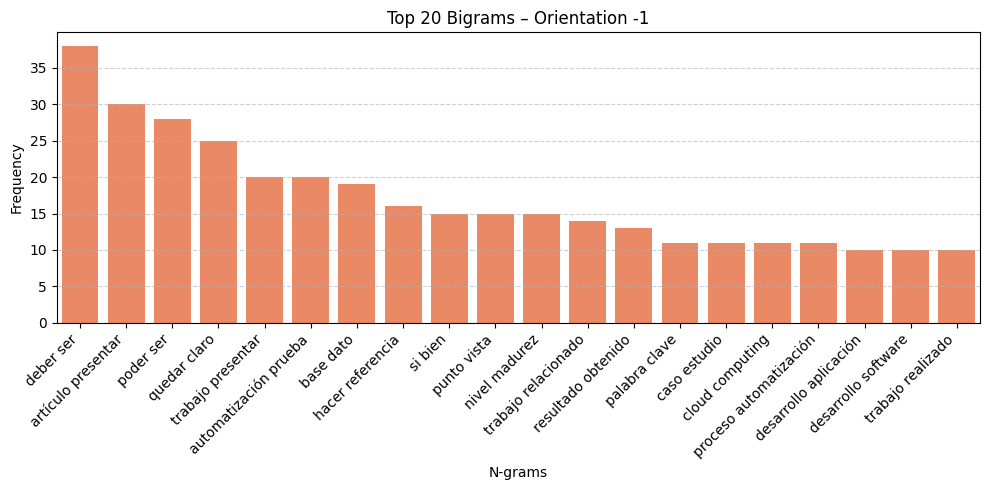

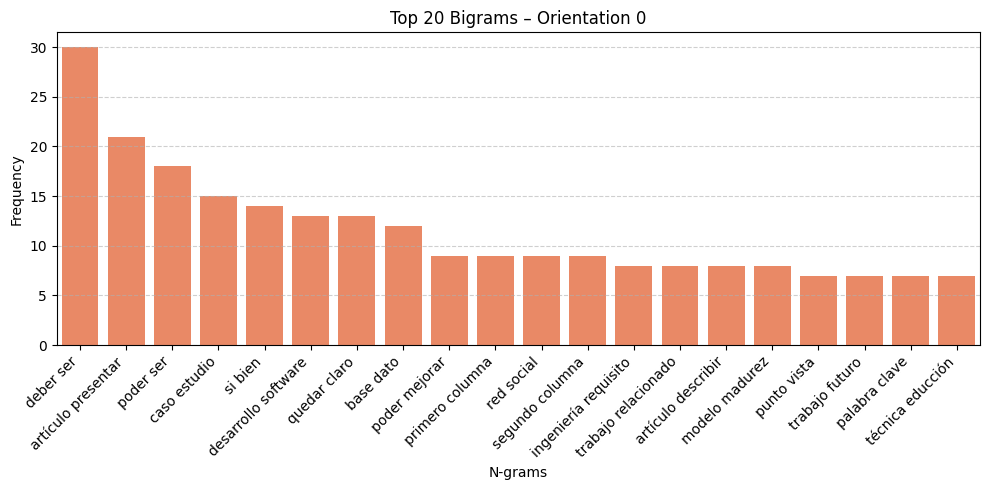

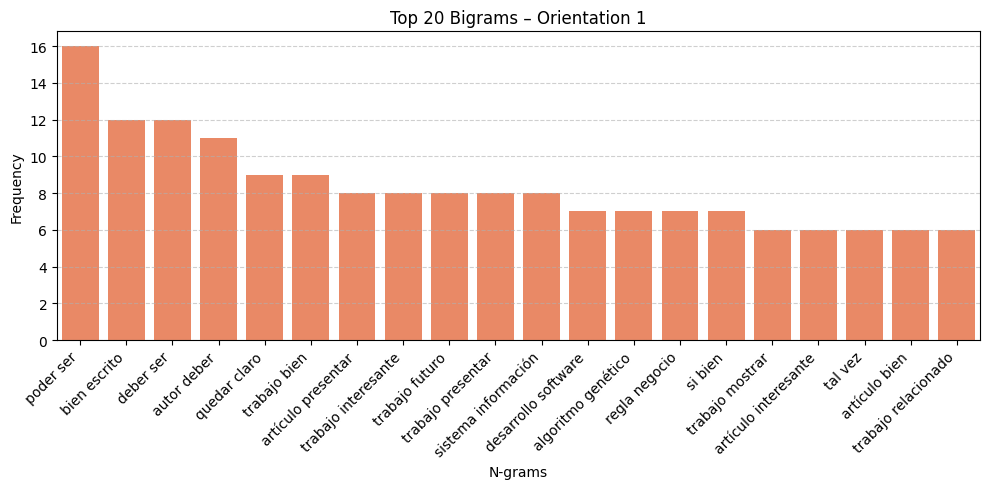

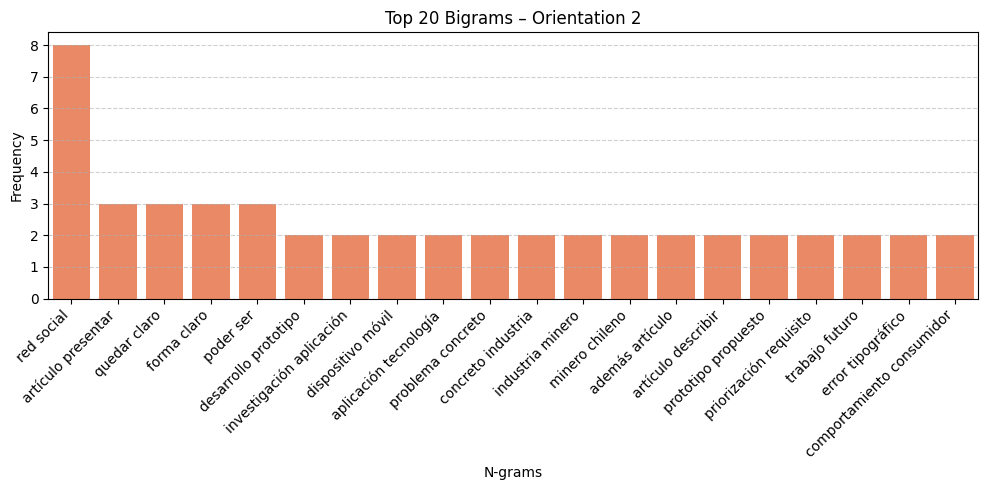

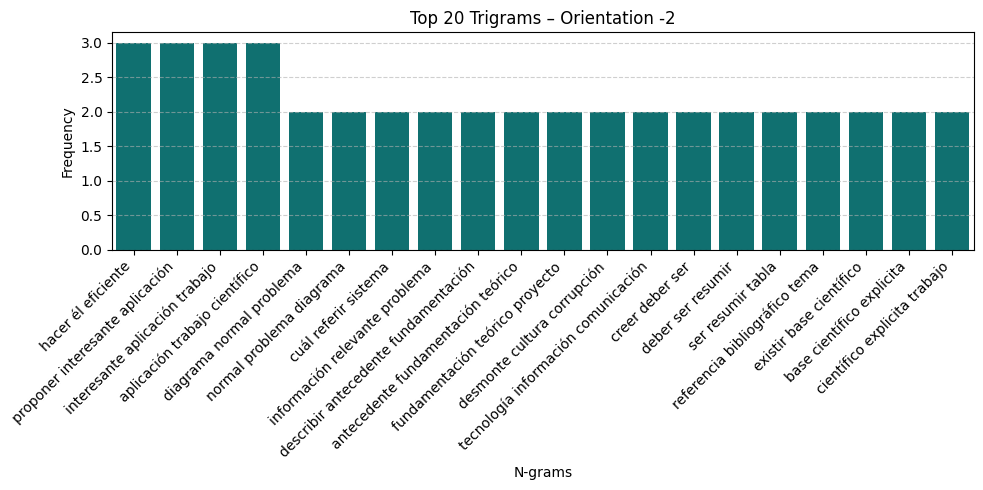

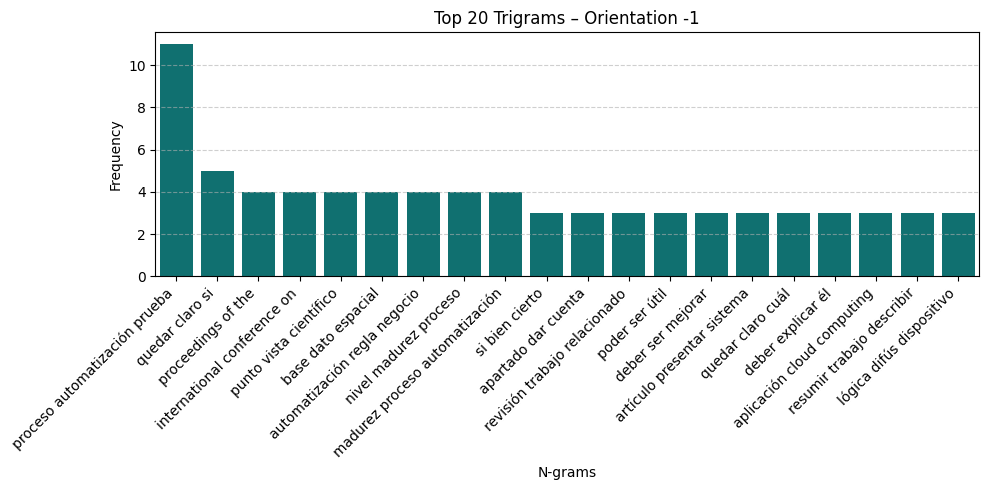

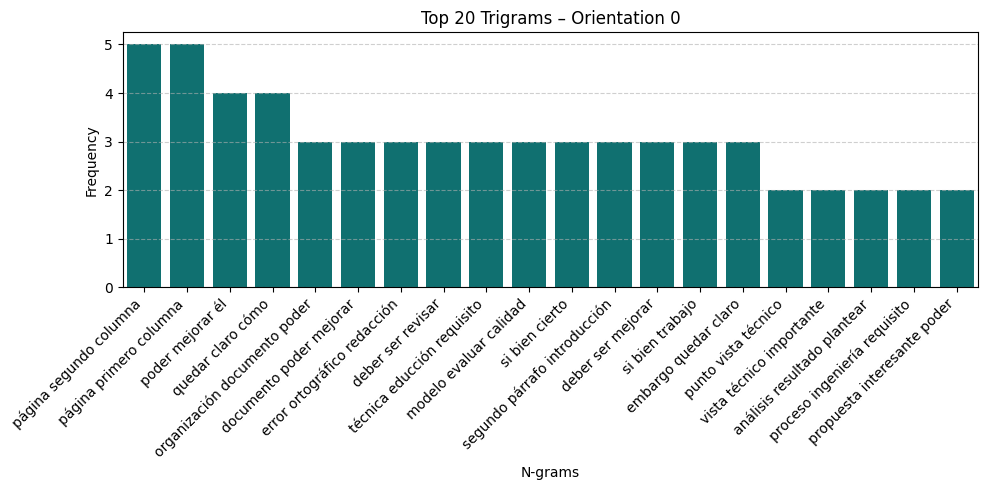

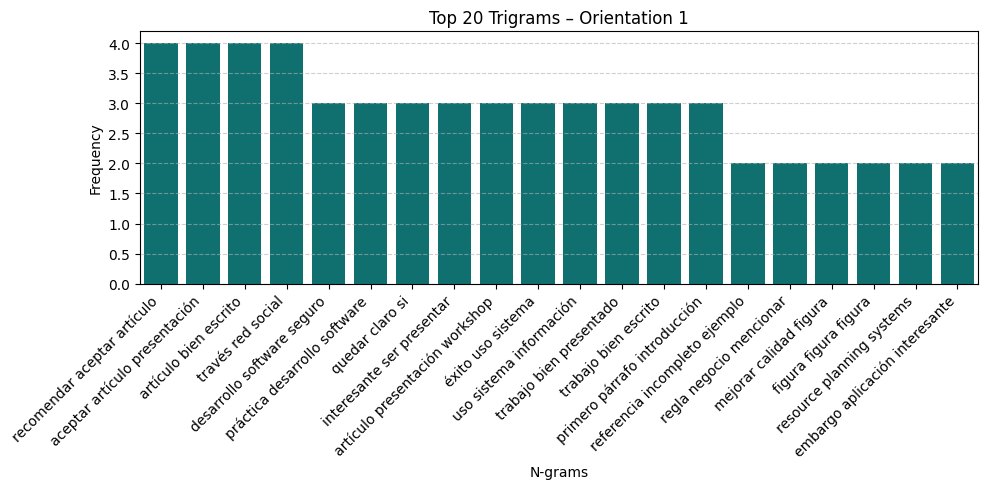

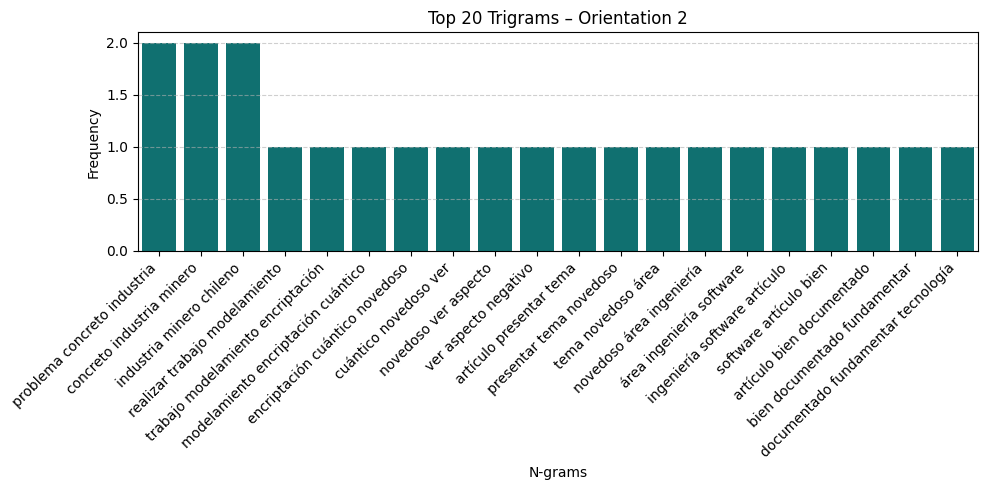

In [8]:
#Phase 4: N-gram Analysis (Bigrams & Trigrams)
from sklearn.feature_extraction.text import CountVectorizer

# Function to extract top n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

def plot_ngrams(ngrams, title, color='coral'):
    words, counts = zip(*ngrams)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(counts), color=color)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("N-grams")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Bigrams by sentiment
for sentiment in sorted(df_cleaned['orientation'].unique()):
    subset = df_cleaned[df_cleaned['orientation'] == sentiment]['cleaned_text']
    bigrams = get_top_ngrams(subset, ngram_range=(2, 2), n=20)
    plot_ngrams(bigrams, f"Top 20 Bigrams – Orientation {sentiment}")

# Trigrams by sentiment
for sentiment in sorted(df_cleaned['orientation'].unique()):
    subset = df_cleaned[df_cleaned['orientation'] == sentiment]['cleaned_text']
    trigrams = get_top_ngrams(subset, ngram_range=(3, 3), n=20)
    plot_ngrams(trigrams, f"Top 20 Trigrams – Orientation {sentiment}", color='teal')


STEP-3: Feature Engineering



Goal: Building a full feature matrix X (text + numeric), and defining a target y.




In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np

# === Step 5.1: TF-IDF Vectorization ===
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)  # Unigrams + bigrams
X_text = tfidf.fit_transform(df_cleaned['cleaned_text'])

# === Step 5.2: Add numeric features ===
numeric_features = ['word_count', 'char_count', 'confidence', 'evaluation']
df_cleaned[numeric_features] = df_cleaned[numeric_features].fillna(0)

# Force numeric types
for col in numeric_features:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

X_numeric = df_cleaned[numeric_features].values.astype('float64')

# === Step 5.3: Combine text + numeric features ===
X = hstack([X_text, X_numeric])


# === Step 5.4: Define Target Variable ===
y = df_cleaned['orientation']

# === Step 5.5: Sanity Check ===
print("Final Feature Matrix shape (X):", X.shape)
print("Target Vector shape (y):", y.shape)
print("Sample of numeric features:\n", df_cleaned[numeric_features].head())


Final Feature Matrix shape (X): (399, 5004)
Target Vector shape (y): (399,)
Sample of numeric features:
    word_count  char_count  confidence  evaluation
0          45         575           4           1
1          50         618           4           1
2         118        1259           5           1
3         119        1350           4           2
4         162        1938           4           2


Logistic Regression – Full Pipeline

✅ Logistic Regression model trained successfully!
🎯 Accuracy: 0.5500

📝 Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         7
          -1       0.62      0.69      0.66        29
           0       0.47      0.32      0.38        22
           1       0.52      0.74      0.61        19
           2       0.50      1.00      0.67         3

    accuracy                           0.55        80
   macro avg       0.42      0.55      0.46        80
weighted avg       0.50      0.55      0.51        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/IPython/c

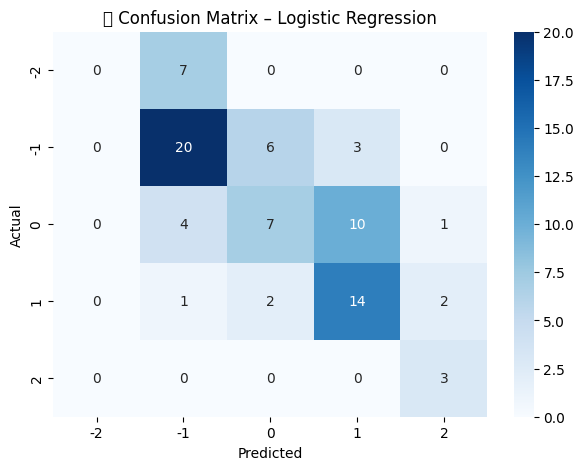

In [10]:
# STEP 6: Logistic Regression – Optimized Final Version

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === 6.1: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 6.2: Initialize Logistic Regression ===
logreg = LogisticRegression(
    max_iter=1000,               # Enough iterations to converge
    solver='liblinear',          # Works well for small/medium datasets
    class_weight='balanced',     # Handles class imbalance
    C=1.0                        # Regularization strength (default, balanced)
)

# === 6.3: Train the model ===
logreg.fit(X_train, y_train)
print("✅ Logistic Regression model trained successfully!")

# === 6.4: Make Predictions ===
y_pred = logreg.predict(X_test)

# === 6.5: Evaluate the Model ===
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Accuracy: {acc:.4f}\n")

print("📝 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📊 Confusion Matrix – Logistic Regression")
plt.show()


Train & Evaluate an SVM on Your Feature Matrix
We'll use:

LinearSVC (since your features are high-dimensional)

class_weight='balanced' (to help class -2 and 2)

Standard train/test evaluation + confusion matrix



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

✅ SVM model trained!
🎯 SVM Accuracy: 0.1625

📝 SVM Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         7
          -1       0.67      0.21      0.32        29
           0       0.00      0.00      0.00        22
           1       0.33      0.21      0.26        19
           2       0.05      1.00      0.10         3

    accuracy                           0.16        80
   macro avg       0.21      0.28      0.13        80
weighted avg       0.32      0.16      0.18        80



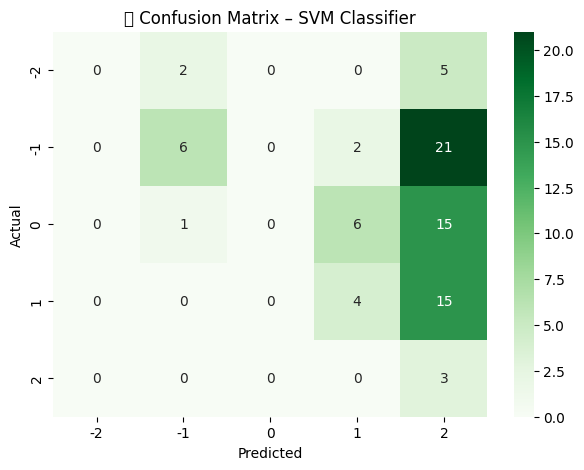

In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# === Train/Test Split (repeated just in case)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === Initialize LinearSVC with balanced classes
svm_clf = LinearSVC(
    class_weight='balanced',
    max_iter=10000,      # Ensure convergence
    C=1.0                # Default regularization strength
)

# === Train
svm_clf.fit(X_train, y_train)
print("✅ SVM model trained!")

# === Predict
y_pred_svm = svm_clf.predict(X_test)

# === Accuracy
acc = accuracy_score(y_test, y_pred_svm)
print(f"🎯 SVM Accuracy: {acc:.4f}")

# === Classification Report
print("\n📝 SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# === Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📊 Confusion Matrix – SVM Classifier")
plt.show()


In [12]:
# STEP: Convert 5-class → 3-class sentiment
def map_sentiment(val):
    if val in [-2, -1]:
        return 0  # Negative
    elif val == 0:
        return 1  # Neutral
    else:
        return 2  # Positive


# Re-map on the 399-row dataframe used to create X
df_cleaned['sentiment_3class'] = df_cleaned['orientation'].apply(map_sentiment)

# Then define the new target
y_3class = df_cleaned['sentiment_3class']


# Check new distribution
print("📊 Sentiment 3-Class Distribution:")
print(y_3class.value_counts().sort_index())




📊 Sentiment 3-Class Distribution:
sentiment_3class
0    177
1    111
2    111
Name: count, dtype: int64


🔍 Logistic Regression (3-Class) Accuracy: 0.6625
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83        36
     Neutral       0.40      0.18      0.25        22
    Positive       0.56      0.86      0.68        22

    accuracy                           0.66        80
   macro avg       0.60      0.63      0.59        80
weighted avg       0.64      0.66      0.63        80



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


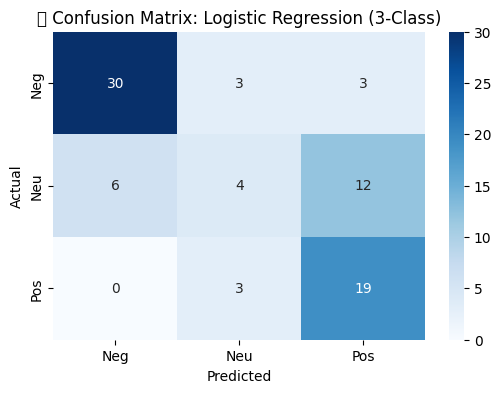

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔍 SVM (3-Class) Accuracy: 0.6750
              precision    recall  f1-score   support

    Negative       0.79      0.92      0.85        36
     Neutral       0.00      0.00      0.00        22
    Positive       0.55      0.95      0.70        22

    accuracy                           0.68        80
   macro avg       0.45      0.62      0.52        80
weighted avg       0.51      0.68      0.57        80



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


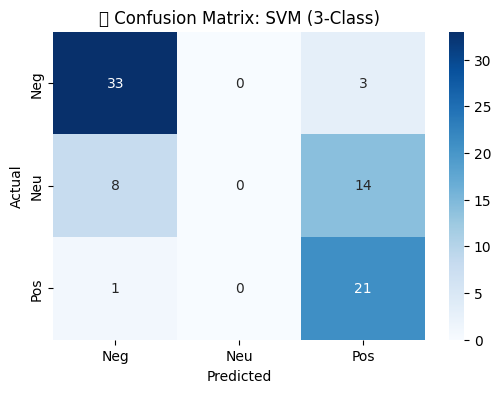

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Split for new target
X_train, X_test, y_train, y_test = train_test_split(
    X, y_3class, test_size=0.2, random_state=42, stratify=y_3class
)

# === Logistic Regression
log_clf = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_test)

# === SVM
svm_clf = LinearSVC(max_iter=10000, class_weight='balanced')
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

# === Evaluation Function
def evaluate_model(y_true, y_pred, title):
    print(f"🔍 {title} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Neg", "Neu", "Pos"],
                yticklabels=["Neg", "Neu", "Pos"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"📊 Confusion Matrix: {title}")
    plt.show()

# === Results
evaluate_model(y_test, y_pred_log, "Logistic Regression (3-Class)")
evaluate_model(y_test, y_pred_svm, "SVM (3-Class)")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Best Parameters: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}

🎯 Tuned Logistic Accuracy: 0.6500

📝 Classification Report (Tuned):
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83        36
     Neutral       0.40      0.27      0.32        22
    Positive       0.55      0.73      0.63        22

    accuracy                           0.65        80
   macro avg       0.60      0.61      0.60        80
weighted avg       0.64      0.65      0.64        80



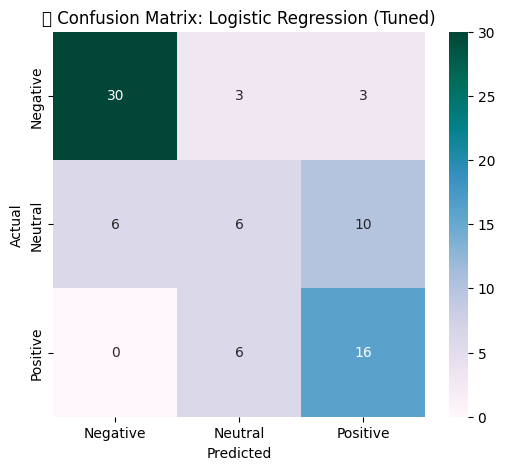

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define param grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [200]
}

# Create base model
log_reg = LogisticRegression(multi_class='multinomial')

# Set up grid search
grid = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Best parameters
print("✅ Best Parameters:", grid.best_params_)

# Predict with best estimator
y_pred = grid.best_estimator_.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Tuned Logistic Accuracy: {acc:.4f}")

# Classification Report
print("\n📝 Classification Report (Tuned):")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='PuBuGn',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("📊 Confusion Matrix: Logistic Regression (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [15]:
import re
import string
import nltk
import spacy
from nltk.corpus import stopwords

# Make sure you're ready for this
nltk.download('stopwords')
nltk.download('punkt')
spacy_es = spacy.load('es_core_news_sm')
stopwords_es = set(stopwords.words('spanish'))

# Rename for clarity
original_df = df.copy()

# Preprocess function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    doc = spacy_es(text)
    return ' '.join([token.lemma_ for token in doc if token.text not in stopwords_es and not token.is_space])

# Apply to create cleaned_text
original_df['cleaned_text'] = original_df['text'].apply(preprocess_text)

# Add numeric features
original_df['word_count'] = original_df['cleaned_text'].apply(lambda x: len(x.split()))
original_df['char_count'] = original_df['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
original_df['confidence'] = pd.to_numeric(original_df['confidence'], errors='coerce').fillna(0)
original_df['evaluation'] = pd.to_numeric(original_df['evaluation'], errors='coerce').fillna(0)

# Map sentiment to 3-class
def map_sentiment(val):
    if val <= -1:
        return 'Negative'
    elif val == 0:
        return 'Neutral'
    else:
        return 'Positive'

original_df['sentiment_3class'] = original_df['orientation'].astype(int).apply(map_sentiment)

print("✅ original_df restored with cleaned_text + sentiment_3class")
print(original_df[['cleaned_text', 'sentiment_3class']].head())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ original_df restored with cleaned_text + sentiment_3class
                                        cleaned_text sentiment_3class
0  artículo abordar problema contingente relevant...          Neutral
1  artículo presentar recomendación práctico desa...         Positive
2  tema interesante poder ser mucho ayuda guía in...         Positive
3  explicar forma ordenado didáctico experiencia ...         Positive
4                                                             Neutral


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3984 - loss: 1.0964 - val_accuracy: 0.4848 - val_loss: 1.0852
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4508 - loss: 1.0832 - val_accuracy: 0.4848 - val_loss: 1.0700
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3982 - loss: 1.0784 - val_accuracy: 0.4848 - val_loss: 1.0466
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4078 - loss: 1.0539 - val_accuracy: 0.4848 - val_loss: 0.9858
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4206 - loss: 0.9443 - val_accuracy: 0.4545 - val_loss: 0.9732
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4920 - loss: 0.8845 - val_accuracy: 0.3939 - val_loss: 0.9981
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.4846 - loss: 0.8999 - val_accuracy: 0.4545 - val_loss: 0.9513
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5512 - loss: 0.8884 - val_accuracy: 0.4848 - v

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


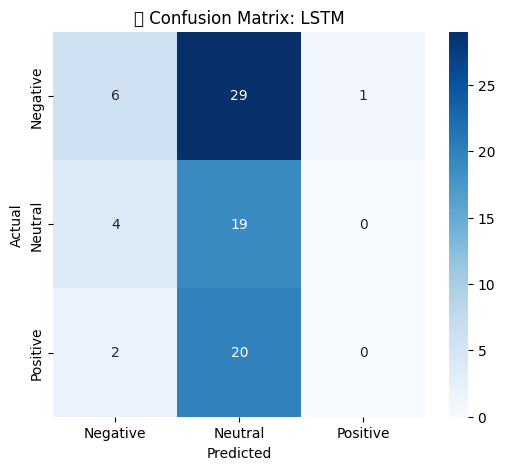

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Tokenize and pad sequences
MAX_VOCAB = 5000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(original_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(original_df['cleaned_text'])
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Step 2: Encode sentiment labels
label_enc = LabelEncoder()
y_lstm = label_enc.fit_transform(original_df['sentiment_3class'])

# Step 3: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm)

# Step 4: Build LSTM model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3-class output
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1)

# Step 6: Predict and evaluate
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 7: Print evaluation
print(f"\n🎯 LSTM Accuracy: {np.mean(y_pred == y_test):.4f}")
print("\n📝 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_enc.classes_))

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_,
            cmap='Blues')
plt.title("📊 Confusion Matrix: LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Upgraded LSTM Pipeline
Key Upgrades:

Pretrained fastText Embeddings (Spanish)

Bidirectional LSTM

Class weights (for class imbalance)

Early stopping (to avoid overfitting)

More epochs for better learning

1️⃣ Download Pretrained fastText Spanish Embeddings

In [17]:
# Only need to do this ONCE in your Colab runtime!
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
!gunzip cc.es.300.vec.gz


2️⃣ Load Embeddings and Prepare Embedding Matrix

In [18]:
import numpy as np

EMBEDDING_DIM = 300
EMBEDDING_FILE = 'cc.es.300.vec'  # Path to the downloaded file

# Load fastText embeddings (may take 1-2 min)
embedding_index = {}
with open(EMBEDDING_FILE, encoding='utf-8') as f:
    next(f)  # Skip header
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index):,} word vectors.")

# Prepare embedding matrix
word_index = tokenizer.word_index
num_words = min(MAX_VOCAB, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_VOCAB:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Loaded 2,000,000 word vectors.


Calculate Class Weights (to handle imbalance)

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: np.float64(0.7659574468085106), 1: np.float64(1.148936170212766), 2: np.float64(1.2134831460674158)}


Build the Bidirectional LSTM Model

In [20]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),  # freeze embeddings for now
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,476,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,476,600 (5.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,476,600 (5.63 MB)

 Train with Early Stopping

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.2985 - loss: 1.1067 - val_accuracy: 0.5152 - val_loss: 1.1002
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.4442 - loss: 1.0805 - val_accuracy: 0.4545 - val_loss: 1.0939
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3944 - loss: 1.0988 - val_accuracy: 0.6061 - val_loss: 1.0570
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5281 - loss: 1.0322 - val_accuracy: 0.6667 - val_loss: 1.0519
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.4786 - loss: 1.0235 - val_accuracy: 0.5455 - val_loss: 1.1163
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.5912 - loss: 0.9808 - val_accuracy: 0.2727 - val_loss: 1.1794
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.5649 - loss: 0.9553 - val_accuracy: 0.6364 - val_loss: 1.0495
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.6368 - loss: 0.9067 - val_accuracy: 0.4848

Evaluate as before


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step

🎯 LSTM Accuracy (Upgraded): 0.4321

📝 Classification Report (Upgraded):
              precision    recall  f1-score   support

    Negative       0.53      0.64      0.58        36
     Neutral       0.33      0.26      0.29        23
    Positive       0.30      0.27      0.29        22

    accuracy                           0.43        81
   macro avg       0.39      0.39      0.39        81
weighted avg       0.41      0.43      0.42        81



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


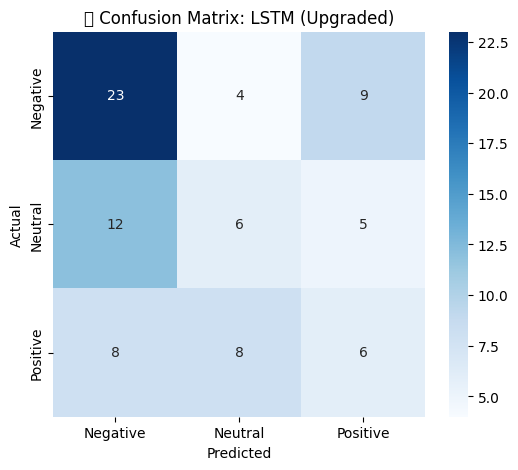

In [22]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"\n🎯 LSTM Accuracy (Upgraded): {np.mean(y_pred == y_test):.4f}")
print("\n📝 Classification Report (Upgraded):")
print(classification_report(y_test, y_pred, target_names=label_enc.classes_))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_,
            cmap='Blues')
plt.title("📊 Confusion Matrix: LSTM (Upgraded)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
